### Programming for Biomedical Informatics
#### Week 8 - Network Clustering & Enrichment Analysis

Constructing networks that are useful representations of the underlying biological data is a complex task. In this notebook we will aim to determine community structure and use enrichment analysis to gain some biological insight into the gene expression network for these patients.

Thanks to Chaeeun Lee who developed parts of these scripts for a workshop on networks presented at ISMB2024 in Montreal, Canada.

Files used in this analysis

- ISMB_TCGA_GE.pkl - contains gene expression data for TCGA samples
- gene_coexpression_network_pearson.gml - base network for the gene coexpression network
- cancer_genome_catalogue.csv - a large meta-data file with annotations for known cancer driver genes
- tcga_ge_df_symbols_t.csv - source of gene symbols from TCGA

These files can be downloaded from [here](https://datasync.ed.ac.uk/index.php/s/OCaDbvK978Ikmig) with password: 'pbi2024'

In [1]:
# import libraries
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from prettytable import PrettyTable
import gseapy as gp

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load the gene coexpression network

# define the data directory
data_dir = './data/'

# Define paths to .gml network files from Section 1
# These paths point to the Gene correlation network, Patient network from (1) TCGA gene expression data and (2) TCGA DNA methylation data.
G_gxp_path = data_dir + 'gene_coexpression_network.gml'

# Load the GML graphs into NetworkX graph objects
# nx.read_gml() function reads a graph from a GML file
G_gxp = nx.read_gml(G_gxp_path)  # Gene correlation network

# Get all nodes in each graph
# The nodes represent genes or patients depending on the network
G_gxp_nodes_list = list(G_gxp.nodes())  # Nodes in the gene correlation network

# Define paths to the raw TCGA datasets
# tcga_dnam_path = 'section2_data/ISMB_TCGA_DNAm.pkl'  # TCGA DNA methylation data
tcga_gxp_path = data_dir + 'ISMB_TCGA_GE.pkl'  # TCGA Gene expression data

# Load the gene expression dataset
# pd.read_pickle() function loads a pickled pandas DataFrame or Series
tcga_gxp = pd.read_pickle(tcga_gxp_path)

# For this example, we'll use a CSV file that includes gene symbols
# pd.read_csv() function loads a CSV file into a pandas DataFrame
tcga_gxp_df = pd.read_csv(data_dir + 'tcga_ge_df_symbols_t.csv') # Dataset with gene symbols
# Set 'GENES' column as the index for easy access to gene-specific data
tcga_gxp_df.set_index('GENES', inplace=True)

# Extract metadata from the gene expression dataset
# Metadata might include information such as patient IDs, sample conditions, etc.
tcga_gxp_meta = tcga_gxp['datMeta']

# Print the number of nodes in each network
# This provides a quick overview of the size of each network
print(f"Number of nodes in gene correlation network: {len(G_gxp_nodes_list)}")


Number of nodes in gene correlation network: 305


In [3]:
# Display the shape of the dataframe
print("\nShape of the dataframe 'tcga_gxp_df' (rows, columns):")
### YOUR CODE HERE ###
print(tcga_gxp_df.shape)

# List the columns in the dataframe
print("\nList of columns in the dataframe 'tcga_gxp_df':")
### YOUR CODE HERE ###
print(tcga_gxp_df.columns)


Shape of the dataframe 'tcga_gxp_df' (rows, columns):
(20244, 498)

List of columns in the dataframe 'tcga_gxp_df':
Index(['TCGA-38-7271', 'TCGA-55-7914', 'TCGA-95-7043', 'TCGA-73-4658',
       'TCGA-86-8076', 'TCGA-55-7726', 'TCGA-44-6147', 'TCGA-50-5932',
       'TCGA-44-2661', 'TCGA-86-7954',
       ...
       'TCGA-97-A4M7', 'TCGA-62-A46R', 'TCGA-50-5055', 'TCGA-38-4628',
       'TCGA-86-7713', 'TCGA-86-8073', 'TCGA-MN-A4N4', 'TCGA-53-7626',
       'TCGA-44-A47G', 'TCGA-55-6969'],
      dtype='object', length=498)


**Network Annotation**

We will use [cancer gene calatogue (CGC)](https://cancer.sanger.ac.uk/census) from the Catalogue Of Somatic Mutations In Cancer (COSMIC) to annotate genes in our network. 

- `'Tier'`
    - To be classified into Tier 1, a gene must possess a documented activity relevant to cancer, along with evidence of mutations in cancer which change the activity of the gene product in a way that promotes oncogenic transformation.
    - Tier 2 consists of genes with strong indications of a role in cancer but with less extensive available evidence.
- `'Hallmark'`
    - New overviews of cancer gene function focused on hallmarks of cancer pull together manually curated information on the function of proteins coded by cancer genes and summarise the data in simple graphical form. They present a condensed overview of most relevant facts with quick access to the literature source, and define whether a gene has a stimulating or suppressive effect via individual cancer hallmarks.

In [4]:
# import the cancer genome catalogue meta-data
cancer_genes_path = data_dir+'cancer_genome_catalogue.csv'
cancer_genes_df = pd.read_csv(cancer_genes_path)
# print(cancer_genes_df.columns)
cancer_genes_df.head(5)

,Gene Symbol,Name,Entrez GeneId,Genome Location,Tier,Hallmark,Chr Band,Somatic,Germline,Tumour Types(Somatic),Tumour Types(Germline),Cancer Syndrome,Tissue Type,Molecular Genetics,Role in Cancer,Mutation Types,Translocation Partner,Other Germline Mut,Other Syndrome,Synonyms
0,A1CF,APOBEC1 complementation factor,29974.0,10:50799421-50885675,2,NaN,10q11.23,yes,NaN,melanoma,NaN,NaN,E,NaN,oncogene,Mis,NaN,NaN,NaN,"ACF,ACF64,ACF65,APOBEC1CF,ASP,CCDS73133.1,ENSG..."
1,ABI1,abl-interactor 1,10006.0,10:26746593-26860935,1,Yes,10p12.1,yes,NaN,AML,NaN,NaN,L,Dom,"TSG, fusion",T,KMT2A,NaN,NaN,"ABI-1,CCDS7150.1,E3B1,ENSG00000136754.17,NM_00..."
2,ABL1,v-abl Abelson murine leukemia viral oncogene h...,25.0,9:130713946-130885683,1,Yes,9q34.12,yes,NaN,"CML, ALL, T-ALL",NaN,NaN,L,Dom,"oncogene, fusion","T, Mis","BCR, ETV6, NUP214",NaN,NaN,"ABL,CCDS35165.1,ENSG00000097007.17,JTK7,NM_007..."
3,ABL2,"c-abl oncogene 2, non-receptor tyrosine kinase",27.0,1:179099327-179229601,1,NaN,1q25.2,yes,NaN,AML,NaN,NaN,L,Dom,"oncogene, fusion",T,ETV6,NaN,NaN,"ABLL,ARG,CCDS30947.1,ENSG00000143322.19,NM_007..."
4,ACKR3,atypical chemokine receptor 3,57007.0,2:236569641-236582358,1,Yes,2q37.3,yes,NaN,lipoma,NaN,NaN,M,Dom,"oncogene, fusion",T,HMGA2,NaN,NaN,"CCDS2516.1,CMKOR1,CXCR7,ENSG00000144476.5,GPR1..."


In [5]:
# subset the dataframe to include only Tier 1 genes
cancer_genes_df = cancer_genes_df[cancer_genes_df['Tier']==1]
cancer_genes = cancer_genes_df['Gene Symbol'].tolist()

# Create the dictionary with node labels as keys and boolean as values
# Complete the dictionary comprehension to check if each node is in the list of cancer genes
found_in_cancer_genes = {node: bool(node in cancer_genes) for node in list(G_gxp.nodes())}

node_attributes={}
node_attributes['cancer_gene'] = found_in_cancer_genes

We are going to use `'KEGG_2021_Human'` as the gene set. KEGG (Kyoto Encyclopedia of Genes and Genomes) is a knowledge base for systematic analysis of gene functions, linking genomic information with higher order functional information [(Kanehisa et al., 2000)](https://doi.org/10.1093/nar/28.1.27).

In [6]:
# Alternative gene sets like 'MSigDB_Hallmark_2020' can also be used (see below).
gene_sets = 'KEGG_2021_Human'

In [7]:
# You can also retrieve and display the list of available gene sets
gene_set_list = gp.get_library_name()
print(gene_set_list)

['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_2023', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'CellMarker_2024', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'ChEA_2022', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'DGIdb_Drug_Targets_2024', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_CRISPR_GeneDependency_CellLines_2023', 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019', 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019', 'Descartes_Cell_Types_and

### Over Representation Analysis (ORA)

Over-representation analysis (ORA) is a method used to identify which predefined gene sets are disproportionately represented in a given set of genes compared to what would be expected by random chance [(Huang et al., 2009)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2615629/). We recommend using Over-representation analysis (ORA) only when Gene Set Enrichment Analysis (GSEA) is not suitable. Although we are using the [`gseapy`](https://doi.org/10.1093/bioinformatics/btac757) library for ORA in this the tutorial, it's important to note that ORA and GSEA are distinct methods.

#### ORA on gene correlation network

In [8]:
# Perform ORA on all nodes in the gene correlation network
enr_all_nodes = gp.enrichr(gene_list=G_gxp_nodes_list, gene_sets=[gene_sets], organism='human') # , outdir=None)

In [9]:
# Display the top 10 enrichment results
enr_all_nodes.results.head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Hematopoietic cell lineage,21/99,1.956377e-18,2.230270e-16,0,0,18.596831,758.293919,HLA-DRB5;ITGAM;CD3G;CD3E;CD3D;CD2;FCER2;CD8B;C...
1,KEGG_2021_Human,Primary immunodeficiency,14/38,1.900053e-16,1.083030e-14,0,0,39.432131,1427.422602,TNFRSF13B;TNFRSF13C;CD3E;IL2RG;CD3D;CD79A;ZAP7...
2,KEGG_2021_Human,Cell adhesion molecules,21/148,1.030400e-14,3.915519e-13,0,0,11.393146,366.930455,HLA-DRB5;ITGAM;ITGB2;PDCD1LG2;SPN;CD2;PTPRC;CD...
3,KEGG_2021_Human,Staphylococcus aureus infection,17/95,7.341998e-14,2.092469e-12,0,0,14.845486,448.965805,C1QB;C1QA;HLA-DRB5;ITGAM;ITGB2;C5AR1;PTAFR;FCG...
4,KEGG_2021_Human,Th17 cell differentiation,17/107,5.637065e-13,1.219280e-11,0,0,12.858218,362.656288,HLA-DRB5;CD3G;CD3E;IL2RG;CD3D;ZAP70;IFNG;IRF4;...
5,KEGG_2021_Human,Th1 and Th2 cell differentiation,16/92,6.417265e-13,1.219280e-11,0,0,14.291750,401.235372,HLA-DRB5;CD3G;CD3E;IL2RG;CD3D;ZAP70;IFNG;LCK;I...
6,KEGG_2021_Human,Graft-versus-host disease,12/42,9.367106e-13,1.525500e-11,0,0,26.846416,743.549140,HLA-DRB5;IFNG;HLA-DPB1;GZMB;HLA-DRA;FASLG;KLRD...
7,KEGG_2021_Human,Intestinal immune network for IgA production,12/48,5.439066e-12,7.750668e-11,0,0,22.365188,580.095130,HLA-DRB5;TNFRSF13B;HLA-DPB1;TNFRSF17;HLA-DRA;T...
8,KEGG_2021_Human,Allograft rejection,11/38,7.229591e-12,9.157482e-11,0,0,27.254724,699.161041,HLA-DRB5;IFNG;HLA-DPB1;GZMB;HLA-DRA;FASLG;HLA-...
9,KEGG_2021_Human,Leishmaniasis,14/77,9.686976e-12,1.104315e-10,0,0,14.991982,380.200236,HLA-DRB5;ITGAM;ITGB2;CYBB;FCGR3A;IFNG;HLA-DPB1...


#### ORA on gene clusters

Clustering on Gene Correlation Network

- We use community detection algorithm to identify communities in the network: 
    - The `greedy_modularity_communities()` function in `networkx` implements a community detection algorithm that optimises modularity using a greedy approach. It iteratively merges pairs of nodes or communities that result in the largest increase in modularity until no further improvement is possible. Modularity measures the density of links inside communities compared to links between communities, aiming to maximise this value to identify densely connected groups within the network.

In [10]:
# Cluster the gene correlation network using the greedy modularity communities algorithm
communities = nx.algorithms.community.modularity_max.greedy_modularity_communities(G_gxp)

# Print the number of detected communities
print(f'The network has {len(communities)} communities.\n')

The network has 4 communities.



Community 1 has 124 nodes.


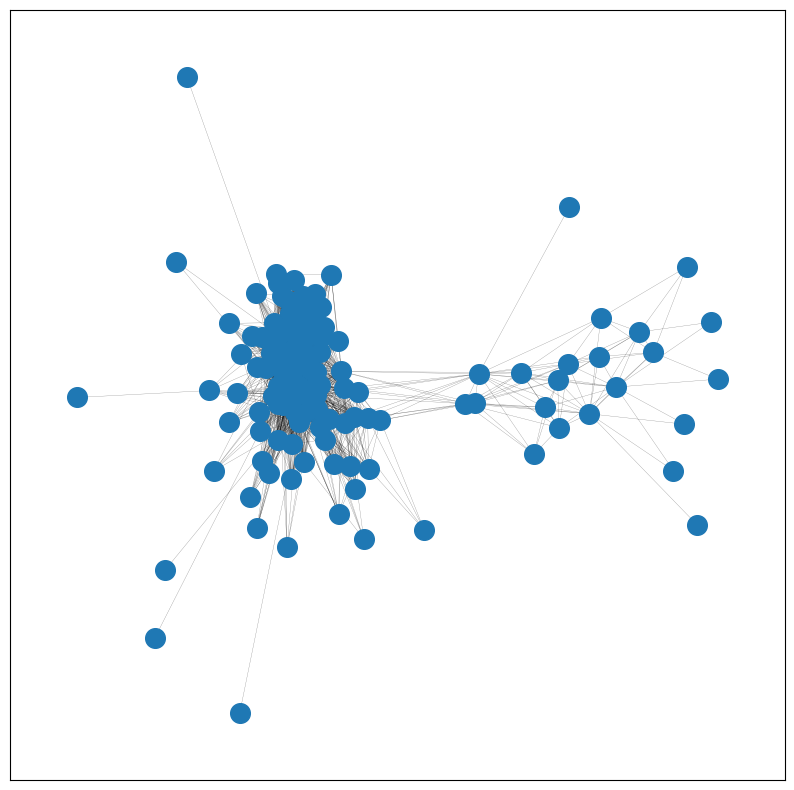

Community 2 has 78 nodes.


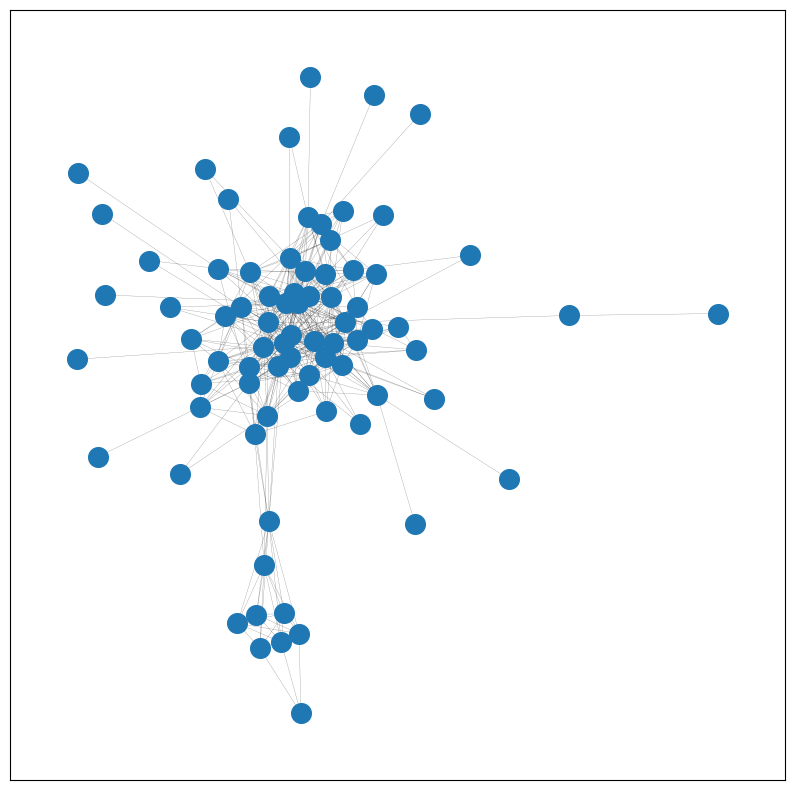

Community 3 has 65 nodes.


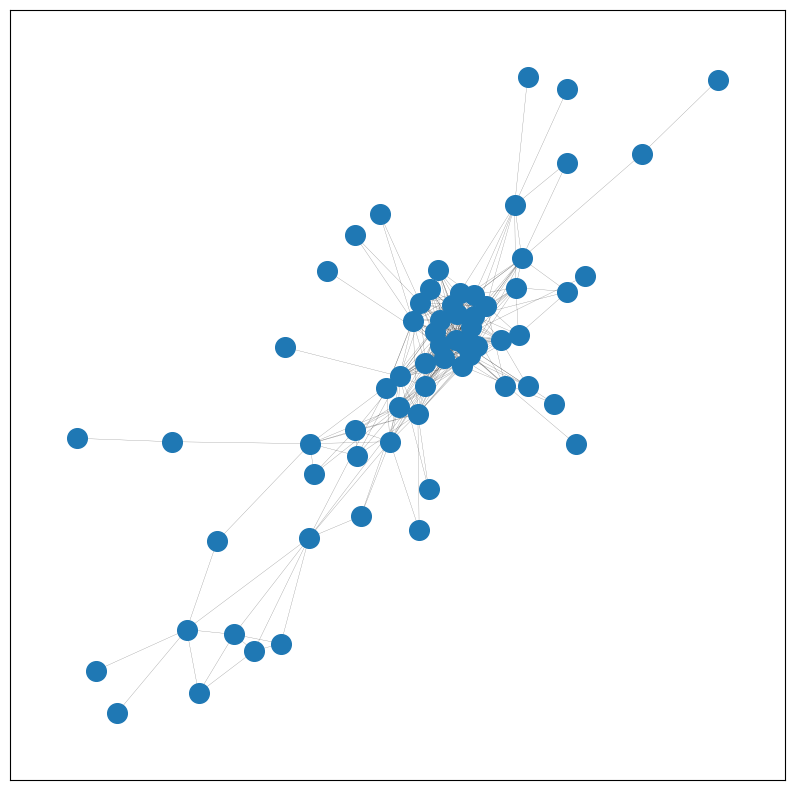

Community 4 has 38 nodes.


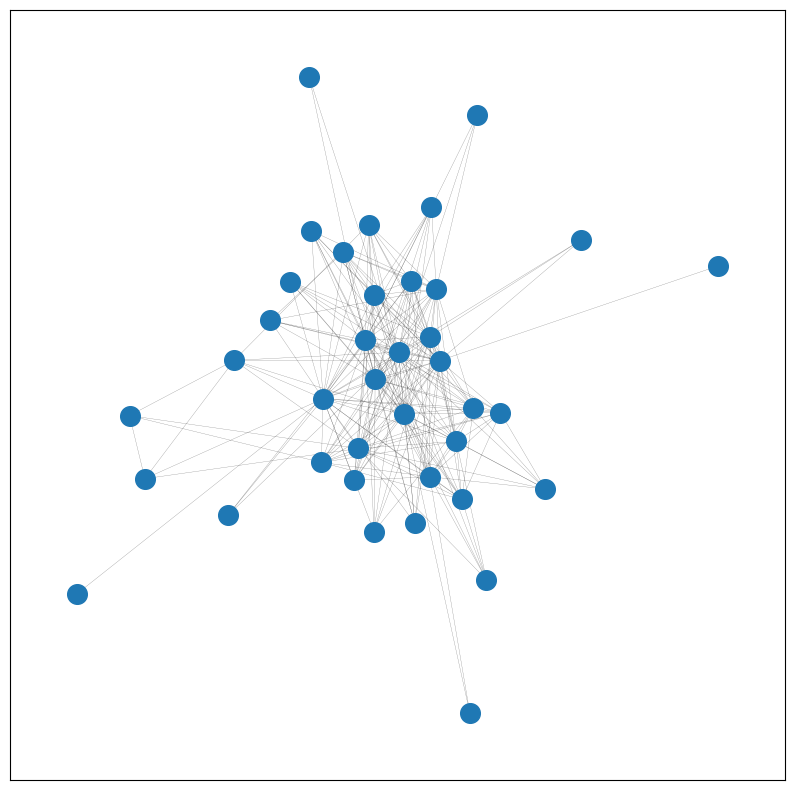

In [11]:
# Create subgraphs for each community
subgraphs = []
for community in communities:
    
    subgraphs.append(G_gxp.subgraph(community))

# Print the number of nodes in each subgraph
# And draw the subgraph
for i, subgraph in enumerate(subgraphs):
    print(f'Community {i+1} has {subgraph.number_of_nodes()} nodes.')
    
    ### YOUR CODE HERE ###
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(subgraph, k=0.1, seed=50)
    nx.draw_networkx_nodes(subgraph, pos, node_size=200, cmap='tab20')
    nx.draw_networkx_edges(subgraph, pos, width=0.2, alpha=0.5)
    
    plt.show() # Forces the plot to be displayed    

**Visualising the Communities**

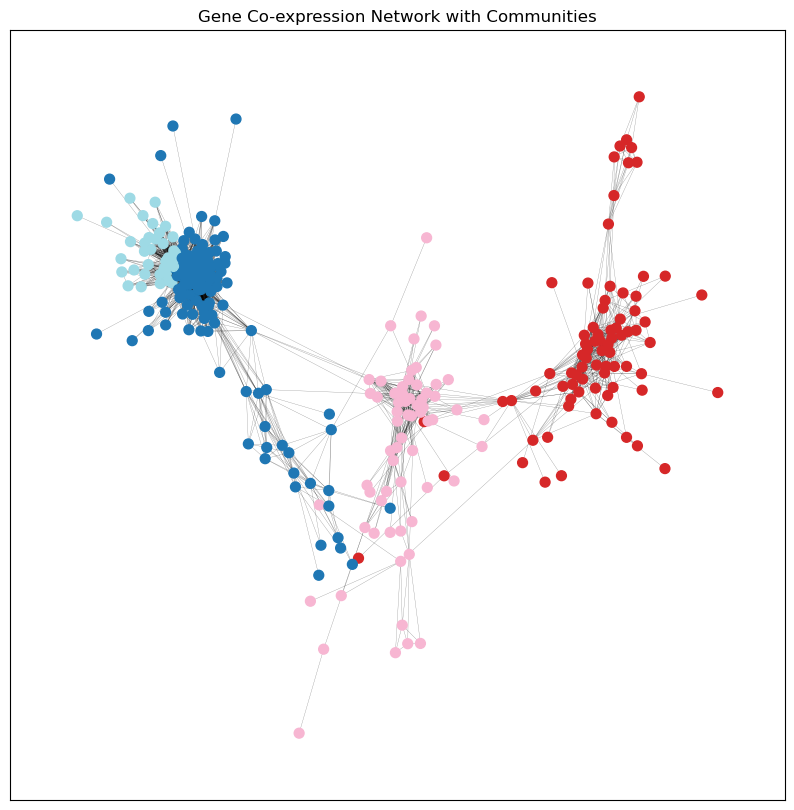

In [12]:
# Visualise the gene correlation network with community memberships
# Visualise the graph with nodes coloured by community
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G_gxp, k=0.1, seed=50)

# create a mapping between nodes and communities
node_community_map = {node: i for i, community in enumerate(communities) for node in community}

# Draw nodes with community colours
node_colors = [node_community_map[node] for node in G_gxp.nodes()]

nx.draw_networkx_nodes(G_gxp, pos, node_size=50, node_color=node_colors, cmap='tab20')
nx.draw_networkx_edges(G_gxp, pos, width=0.2, alpha=0.5)

plt.title('Gene Co-expression Network with Communities')
plt.show()

Performing ORA on individual clusters can help in understanding distinct biological significance of each cluster, revealing how certain pathways or functions are associated with specific subsets of genes.

In [13]:
# Function to perform ORA on a given list of genes
def communityORA(genes):
    enr = gp.enrichr(gene_list=genes, gene_sets=[gene_sets], organism='human', outdir=None)
    return enr

# convert communities to lists for ORA 2. Sort the list of communities by their length in descending order
communities = [list(community) for community in communities]
communities = sorted(communities, key=len, reverse=True)

# perform ORA for three selected communities
community1_enr = communityORA(communities[0])
community2_enr = communityORA(communities[1])
community3_enr = communityORA(communities[2])

# print the top 10 results for each community
x = PrettyTable()
x.field_names = ["Community 1", "Community 2", "Community 3"]
for i in range(10):
    x.add_row([community1_enr.results['Term'][i], community2_enr.results['Term'][i], community3_enr.results['Term'][i]])
print(x)


+----------------------------------------------+---------------------------------+---------------------------------------------------------------+
|                 Community 1                  |           Community 2           |                          Community 3                          |
+----------------------------------------------+---------------------------------+---------------------------------------------------------------+
|           Primary immunodeficiency           | Staphylococcus aureus infection |               T cell receptor signaling pathway               |
|      B cell receptor signaling pathway       |            Phagosome            | Viral protein interaction with cytokine and cytokine receptor |
| Intestinal immune network for IgA production |          Leishmaniasis          |                    Primary immunodeficiency                   |
|          Hematopoietic cell lineage          |   Systemic lupus erythematosus  |             Cytokine-cytokine recep

### Gene Set Enrichment Analysis (GSEA)

Gene Set Enrichment Analysis (GSEA) is a genome-wide expression analysis method designed to interpret expression profiles focusing on pre-defined gene sets [(Subramanian et al., 2005)](https://doi.org/10.1073/pnas.0506580102). These gene sets are curated based on prior biological knowledge, such as published information about biochemical pathways or patterns of coexpression observed in previous experimental studies. The genes can be ordered in a ranked list, according to their differential expression between the classes. The primary objective of GSEA is to assess whether the genes within a given gene set tend to occur toward the top (or bottom) of the ranked list. This ranking is based on the correlation between gene expression and a particular phenotypic class distinction. By evaluating the distribution of gene set members within the ranked list, GSEA identifies whether the set is correlated with the phenotypic class, thus providing insights into underlying biological mechanisms. This method contrasts with traditional single-gene analysis by focusing on the collective behavior of gene sets, thereby uncovering biologically significant patterns that might be overlooked when examining individual genes in isolation. We use `gseapy` to perform GSEA with various gene sets from the MSigDB Database.

<!-- (https://pnnl-comp-mass-spec.github.io/proteomics-data-analysis-tutorial/gsea.html) for referencing.  -->


In [14]:
# Display the first five rows of the dataframe "tcga_gxp_df"
tcga_gxp_df.head(5)

,TCGA-38-7271,TCGA-55-7914,TCGA-95-7043,TCGA-73-4658,TCGA-86-8076,TCGA-55-7726,TCGA-44-6147,TCGA-50-5932,TCGA-44-2661,TCGA-86-7954,...,TCGA-97-A4M7,TCGA-62-A46R,TCGA-50-5055,TCGA-38-4628,TCGA-86-7713,TCGA-86-8073,TCGA-MN-A4N4,TCGA-53-7626,TCGA-44-A47G,TCGA-55-6969
GENES,,,,,,,,,,,,,,,,,,,,,
TSPAN6,11.3668,11.5434,11.4110,12.2149,11.2882,11.2084,11.1717,12.1281,11.9908,12.2601,...,11.4336,11.4533,11.8079,11.3954,12.2414,10.7676,11.6560,10.8912,11.3200,10.5764
DPM1,10.3673,10.5282,11.2018,10.3249,10.2095,11.6034,10.5684,10.5895,10.8699,10.8979,...,9.8932,10.7229,10.7633,11.0195,10.5073,10.5503,11.0739,10.1742,9.9137,10.9022
SCYL3,9.7884,9.7292,9.4449,9.2340,9.8186,9.0884,10.2428,10.1989,9.8516,9.7973,...,9.2713,9.7087,9.3311,9.7850,10.4121,9.0277,9.5578,9.6307,9.3312,9.3425
FIRRM,8.2552,7.9951,8.3546,7.7537,7.9844,8.7984,8.8721,8.3550,8.1877,9.2347,...,8.1065,8.5633,7.7298,9.3048,10.0026,8.2811,8.7883,8.0179,7.8703,8.8147
FGR,10.6173,8.4858,7.3211,11.0656,10.5213,9.3386,9.3440,8.7403,10.6243,9.8945,...,10.4030,10.2213,10.3702,8.7169,8.1769,9.9471,8.9532,10.6328,11.3029,9.6115


In [15]:
# Display the first three rows of the metadata dataframe "tcga_gxp_meta"
tcga_gxp_meta.head(3)

,patient,race,gender,sample_type,cigarettes_per_day,Smoked,sizeFactor,replaceable
_row,,,,,,,,
TCGA-38-7271,TCGA-38-7271,white,female,Primary Tumor,1.3699,Smoker,0.5841,True
TCGA-55-7914,TCGA-55-7914,white,female,Primary Tumor,0.274,Smoker,0.9873,True
TCGA-95-7043,TCGA-95-7043,white,female,Primary Tumor,2.1918,Smoker,0.5439,True


Assign classes based on phenotypic attributes in metadata (e.g., smoking status)

In [16]:
# Create a dictionary to store the class assignments for each sample
classes = {}

# Iterate through the columns (samples)
for sample in tcga_gxp_df.loc[G_gxp_nodes_list].columns: # ".loc[G_gxp_nodes_list]" grabs rows of specified gene symbols
    
    # Assign class labels based on the smoking status from the metadata
    
    if tcga_gxp_meta.loc[sample, 'Smoked'] == 'Smoker':
        classes[sample] = 'smoker' 
    elif tcga_gxp_meta.loc[sample, 'Smoked'] == 'Never':
        classes[sample] = 'control'
    else:
        pass


In [17]:
# show the first 10 class assignments
list(classes.items())[:10]

[('TCGA-38-7271', 'smoker'),
 ('TCGA-55-7914', 'smoker'),
 ('TCGA-95-7043', 'smoker'),
 ('TCGA-73-4658', 'smoker'),
 ('TCGA-86-8076', 'control'),
 ('TCGA-55-7726', 'smoker'),
 ('TCGA-44-6147', 'control'),
 ('TCGA-50-5932', 'control'),
 ('TCGA-44-2661', 'control'),
 ('TCGA-86-7954', 'smoker')]

In [18]:
# you can index the dataframe using the list of nodes
tcga_gxp_df.loc[G_gxp_nodes_list].head(2)

,TCGA-38-7271,TCGA-55-7914,TCGA-95-7043,TCGA-73-4658,TCGA-86-8076,TCGA-55-7726,TCGA-44-6147,TCGA-50-5932,TCGA-44-2661,TCGA-86-7954,...,TCGA-97-A4M7,TCGA-62-A46R,TCGA-50-5055,TCGA-38-4628,TCGA-86-7713,TCGA-86-8073,TCGA-MN-A4N4,TCGA-53-7626,TCGA-44-A47G,TCGA-55-6969
GENES,,,,,,,,,,,,,,,,,,,,,
IGKV1OR2-6,6.9731,7.2456,5.0121,5.0693,6.3777,5.5292,6.0100,5.0365,7.1301,3.712,...,6.2651,4.6626,7.3429,3.7710,4.0026,3.9804,4.5982,6.3521,4.9759,8.1768
PLEK,12.2272,9.9343,8.6000,11.6869,11.4623,10.1335,10.0339,9.3803,12.2897,12.131,...,11.1193,10.5010,11.9146,10.7848,9.5071,10.5512,9.5057,11.7262,11.2868,11.0328


In [19]:
# query the MSigDB database for the gene sets
# https://www.gsea-msigdb.org/gsea/msigdb/index.jsp
from gseapy import Msigdb
msig = Msigdb()
# picking the Human Cancer Cell Atlas
gene_sets = msig.get_gmt(category='c4.3ca', dbver="2024.1.Hs")
# # picking the Human Gene Ontology Biological Process
# gene_sets = msig.get_gmt(category='c5.go.bp', dbver="2024.1.Hs")

In [20]:
# Perform GSEA using the prepared data and class assignments
gs_res = gp.gsea(data=tcga_gxp_df.loc[G_gxp_nodes_list], gene_sets=gene_sets, cls=list(classes.values()), permutation_num=100, outdir=None, method='signal_to_noise', threads=4, seed=7)

# Display the top results from the GSEA
gs_res.res2d.head()

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,GAVISH_3CA_METAPROGRAM_B_CELLS_MHC_II,-0.831078,-1.811314,0.0,0.0,0.0,10/15,10.16%,HLA-DRB1;HLA-DPB1;HLA-DRA;CD74;LY86;HLA-DPA1;H...
1,gsea,GAVISH_3CA_METAPROGRAM_MACROPHAGES_LIPID_ASSOC...,-0.726898,-1.374571,0.134615,0.305221,0.307692,13/15,28.52%,MSR1;TREM2;GPR34;FOLR2;VSIG4;SLCO2B1;MS4A4A;AP...
2,gsea,GAVISH_3CA_MALIGNANT_METAPROGRAM_36_IG,0.468689,1.030859,0.45614,0.478088,0.64,15/22,40.00%,IGHG1;IGHG3;IGHGP;FCRL5;IGLC3;IGLV3-21;IGLV3-1...
3,gsea,GAVISH_3CA_METAPROGRAM_CD8_T_CELLS_CYTOTOXIC,-0.410614,-0.895376,0.66,0.792503,0.736264,7/20,19.34%,HLA-DRB1;HLA-DPB1;HLA-DRA;HLA-DPA1;ALOX5AP;ITG...
4,gsea,GAVISH_3CA_METAPROGRAM_CD4_T_CELLS_CYTOTOXIC,-0.432596,-0.886509,0.673469,0.598394,0.736264,7/19,19.34%,HLA-DRB1;HLA-DPB1;HLA-DRA;HLA-DPA1;ALOX5AP;ITG...


#### Visualising GSEA Results

Once you have performed GSEA, the next step is to visualise the results. Visualisation helps in interpreting the biological roles of the enriched gene sets. Here, we visualise GSEA results with Barcode Enrichment Plot, Heatmap, Clustermap, and Dot Plot. 

**Barcode Enrichment Plot**

Barcode Enrichment Plot shows the positions of members of a given gene set in a ranked list of enrichment scores for the top enriched terms. The scores are ranked left to right from smallest to largest. The ranked scores are represented by a shaded bar, forming a pattern like a barcode. 

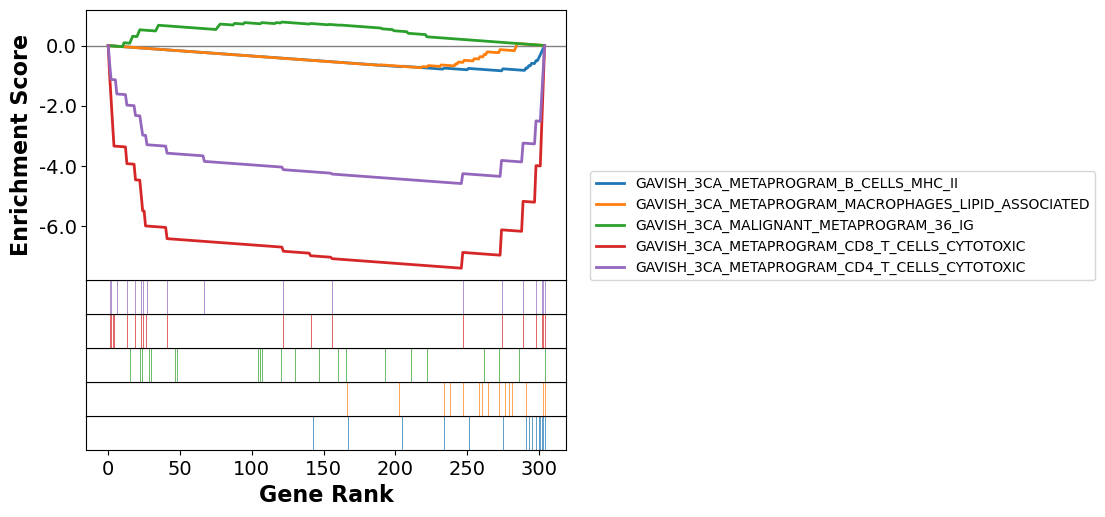

In [21]:
# Extract the enriched terms from the GSEA results. The terms represent pathways or functional categories that are significantly enriched in the dataset.
terms = gs_res.res2d.Term

# Plot the top 5 enriched terms
# The plot function visualizes the enrichment results
axs = gs_res.plot(terms[:5], show_ranking=False, legend_kws={'loc': (1.05, 0)})

You can view and extract leading-edge genes from GSEA results. Leading-edge genes are the subset of genes that contribute most to the enrichment score.

In [22]:
# View leading-edge genes from the GSEA results. 
gs_res.res2d[['Term', 'Lead_genes']].head(10)

,Term,Lead_genes
0,GAVISH_3CA_METAPROGRAM_B_CELLS_MHC_II,HLA-DRB1;HLA-DPB1;HLA-DRA;CD74;LY86;HLA-DPA1;H...
1,GAVISH_3CA_METAPROGRAM_MACROPHAGES_LIPID_ASSOC...,MSR1;TREM2;GPR34;FOLR2;VSIG4;SLCO2B1;MS4A4A;AP...
2,GAVISH_3CA_MALIGNANT_METAPROGRAM_36_IG,IGHG1;IGHG3;IGHGP;FCRL5;IGLC3;IGLV3-21;IGLV3-1...
3,GAVISH_3CA_METAPROGRAM_CD8_T_CELLS_CYTOTOXIC,HLA-DRB1;HLA-DPB1;HLA-DRA;HLA-DPA1;ALOX5AP;ITG...
4,GAVISH_3CA_METAPROGRAM_CD4_T_CELLS_CYTOTOXIC,HLA-DRB1;HLA-DPB1;HLA-DRA;HLA-DPA1;ALOX5AP;ITG...


**Heatmap Visualisation**

`gseapy` provides a heatmap function to visualise the expression levels of the leading-edge genes. The heatmap provides a visual representation of how these genes are expressed across different samples in relation to their assigned phenotypic classes. 

In [23]:
# Import the heatmap function from gseapy
from gseapy import heatmap

# Select the index of the term to visualize
i = 3

# Extract the genes contributing to the enrichment of the selected term
genes = gs_res.res2d.Lead_genes[i].split(";")
print(genes)

['HLA-DRB1', 'HLA-DPB1', 'HLA-DRA', 'HLA-DPA1', 'ALOX5AP', 'ITGB2', 'KLRB1']


[]

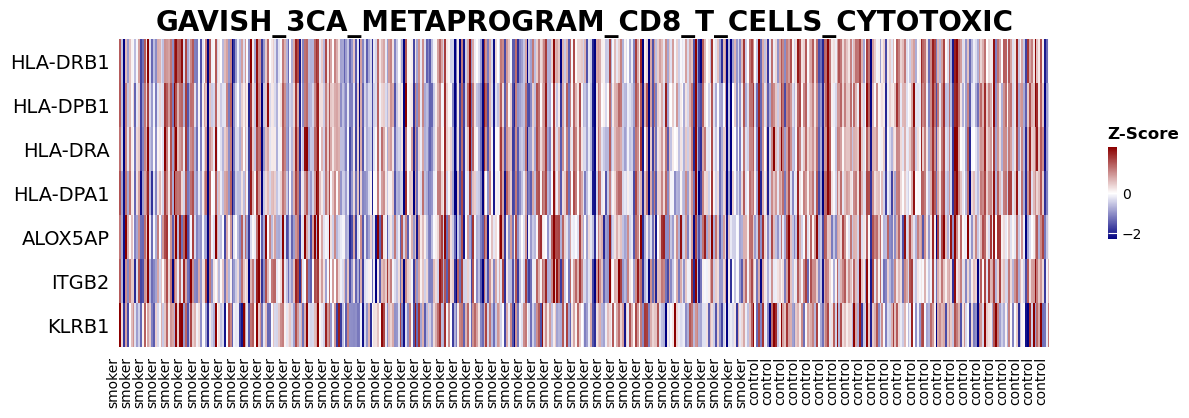

In [24]:
# Generate a heatmap of the expression levels of the leading-edge genes
ax = heatmap(df=gs_res.heatmat.loc[genes], z_score=0, title=terms[i], figsize=(15, 4))

# Update the x-tick labels with the class labels
xtick_labels = [classes[item.get_text()] for item in ax.get_xticklabels()]
ax.set_xticklabels(xtick_labels, size=10, rotation=90, ha='right')
ax.plot()

**Clustermap Visualisation**

The function `clustermap` from `seaborn` is used to create a clustered heatmap. It not only shows the expression levels of the leading-edge genes but also clusters them based on similarity, providing additional insights into gene expression patterns. The cluster map includes dendrograms, which show the hierarchical clustering of both genes and samples, helping to identify groups of co-expressed genes and similar samples.

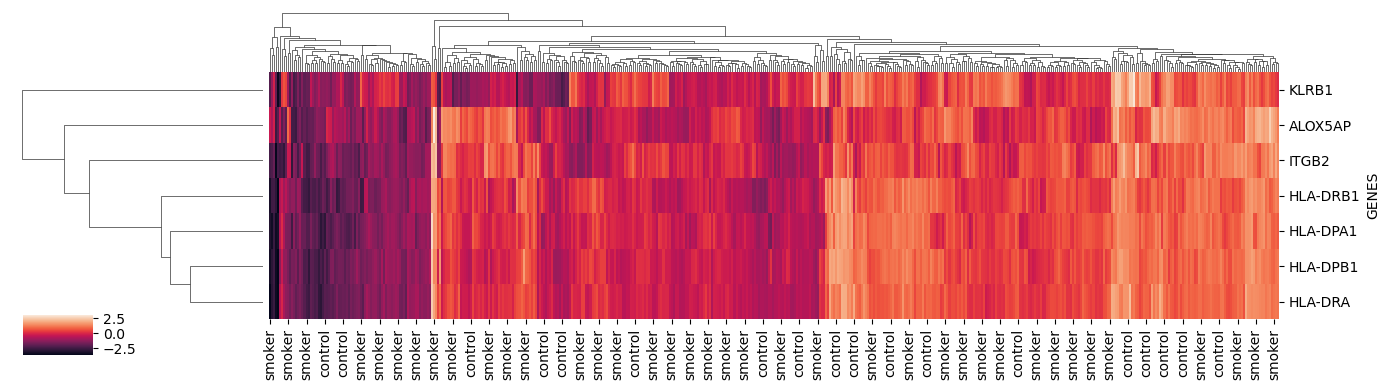

In [25]:
# Import the clustermap function from seaborn
from seaborn import clustermap

# Select the index of the term to visualize
i = 3

# Extract the genes contributing to the enrichment of the selected term
genes = gs_res.res2d.Lead_genes[i].split(";")

# Extract the relevant subset of the heatmap data
data = gs_res.heatmat.loc[genes]

# Rename the columns based on the class assignments
data.rename(columns=classes, inplace=True)

# Generate a cluster map of the expression levels of the leading-edge genes
ax = clustermap(
    data=data,  # The data to cluster
    method='average',  # Clustering method
    metric='euclidean',  # Distance metric
    z_score=0,  # Standardize the data along the rows
    figsize=(14, 4),  # Size of the figure
    dendrogram_ratio=0.2,  # Ratio of the dendrogram
    colors_ratio=0.03,  # Ratio of the colors
    cbar_pos=(0.02, 0.1, 0.05, 0.1)  # Position of the color bar
)

**Dot Plot Visualisation**

Use the `dotplot` function in `gseapy` to create a visual representation of the GSEA results. Here we use "FDR q-val" to determine the dot sizes, which represents the false discovery rate adjusted p-values. We display normalised enrichment score (NES) value as the x-axis. 

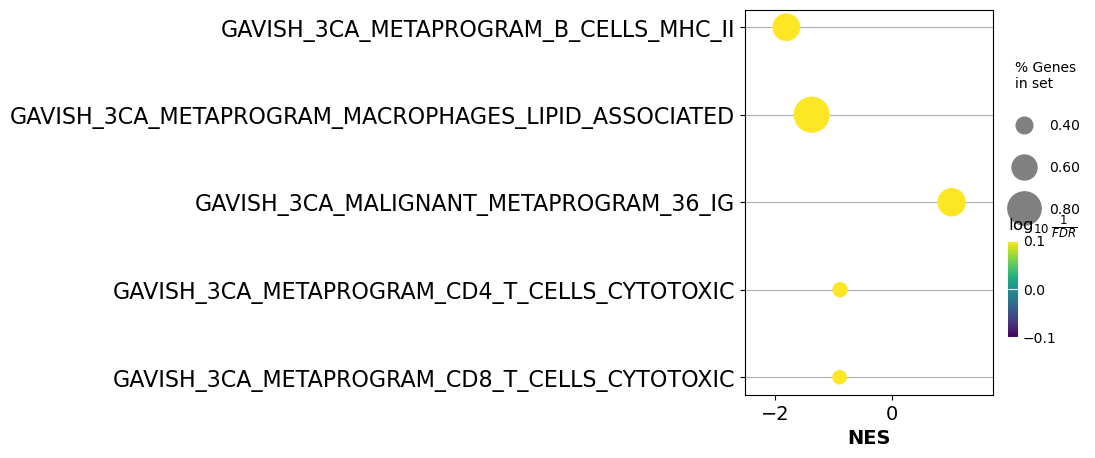

In [26]:
# Import the dotplot function from gseapy
from gseapy import dotplot

# Generate the dot plot for the GSEA results
# The dotplot function visualizes the enrichment results, focusing on the FDR q-values
ax = dotplot(gs_res.res2d,
             column="FDR q-val",  # Column to be used for dot size
            #  title=gene_sets[0],  # Title the plot as the chosen gene set name 
             cmap=plt.cm.viridis,  # Color map for the dots
             size=5,  # Size of the dots
             figsize=(4, 5),  # Size of the figure
             cutoff=1)  # Cutoff for displaying the terms

#### GSEA on Clusters

Similarly to ORA, GSEA can also be performed on individual communities after clustering. This allows for a more granular analysis, revealing pathways and functions that are enriched within particular subgroups of the data.


In [27]:
# Define a function to perform GSEA on a given list of genes (community)
def communityGSEA(genes, gene_sets=gene_sets, classes=classes):
    gs_res = gp.gsea(data=tcga_gxp_df.loc[genes], gene_sets=gene_sets, cls=list(classes.values()), permutation_num=100, outdir=None, method='signal_to_noise', threads=4, seed=7, min_size=1) 
    return gs_res

# Perform GSEA for three community gene sets
community1_gsea = communityGSEA(communities[0])
community2_gsea = communityGSEA(communities[1]) 
community3_gsea = communityGSEA(communities[2])


In [28]:
# Display the top results for the third community
community3_gsea.res2d.head()

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,GAVISH_3CA_METAPROGRAM_CD8_T_CELLS_CYTOTOXIC,0.691703,1.715005,0.019231,0.095408,0.07,10/13,32.31%,GZMB;IFNG;KLRD1;ZNF683;CCL4;GZMH;CXCR6;NKG7;TI...
1,gsea,GAVISH_3CA_METAPROGRAM_CD4_T_CELLS_CYTOTOXIC,0.614892,1.608813,0.035714,0.113298,0.16,9/13,32.31%,GZMB;IFNG;PDCD1;CCL4;GZMH;CXCR6;NKG7;CCL5;GZMA
2,gsea,GAVISH_3CA_METAPROGRAM_CD8_T_CELLS_HEAT_SHOCK,0.911255,1.350688,0.078431,0.528722,0.58,1/2,4.62%,IFNG
3,gsea,GAVISH_3CA_METAPROGRAM_B_CELLS_MHC_II,-1.0,-1.347101,0.037736,0.68294,0.57,1/1,3.08%,CD48
4,gsea,GAVISH_3CA_METAPROGRAM_MACROPHAGES_MAC_1,-1.0,-1.347101,0.037736,0.68294,0.57,1/1,3.08%,CD48


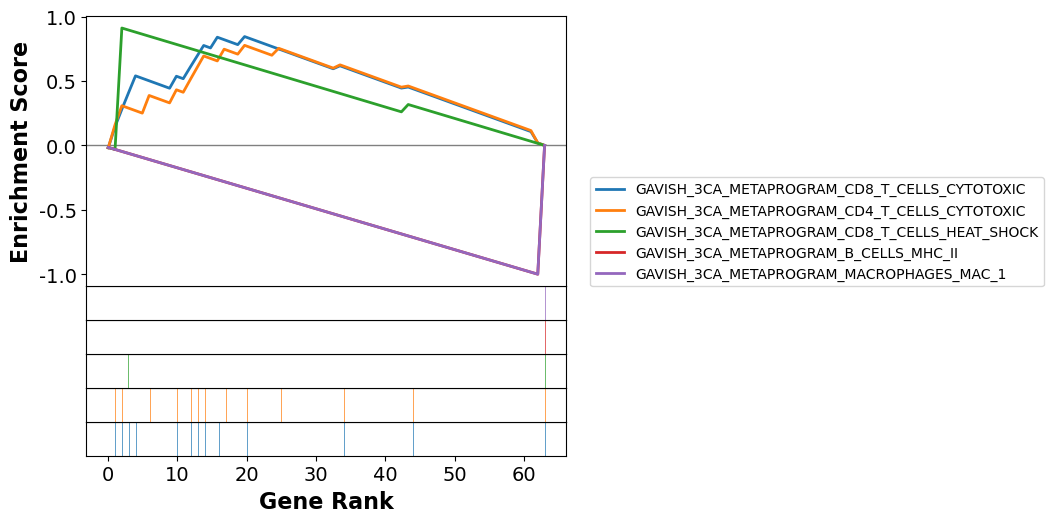

In [29]:
# Extract the enriched terms from the GSEA results for the third community
terms = community3_gsea.res2d.Term

# Plot the top 5 enriched terms for the first community
axs = community3_gsea.plot(terms[:5], show_ranking=False, legend_kws={'loc': (1.05, 0)})